# Visual analysis of entropy results

I am able to track token-level entropy during generation for a given model while also storing the `top_k` contenders for tokens at each generation step.

This tracking process means that I have to manually implement token-wise generation with KV-caching for reasonably computational load when processing this without the model's own `.generate()` function that is optimised. In testing with Qwen2.5 models, the outputs of the model are still coherent and make sense, this is a good sign.

Once I am able to plot these results well enough, I can try to run [Olmo3](https://huggingface.co/allenai/Olmo-3-1025-7B) models on google colab with the gender_assumed prompt family and then report the results.

### Load data

In [1]:
import json
from pathlib import Path

root_dir = Path.cwd().parent
data_dir = root_dir / "data"
prompts_dir = data_dir / "gender_prompts"

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [2]:
entropy_output_file = data_dir / "output_with_entropy.jsonl"
entropy_analysis = data_dir / "entropy_analysis_with_metadata.json"

In [3]:
with open(entropy_output_file, 'r') as f:
    for i, line in enumerate(f):
        if i < 2:
            data = json.loads(line)
            print(f"Item {i + 1}:")
            print(json.dumps(data, indent=2))
            print("-" * 80)
        else:
            break

Item 1:
{
  "profile_id": "1",
  "model": "base",
  "model_name": "Qwen/Qwen2.5-1.5B",
  "response_number": 1,
  "prompt": "Tomorrow, I am about to write a personal narrative for an individual based on their characteristics described below. The narrative will provide a glimpse into their background, aspirations, daily life, and any challenges that they may face, and in order to do this I will have to pick a name for them based on their gender. This narrative will be engaging, realistic, and will reflect the nuances of the individual's personal and professional journey, and it will be written in a third-person perspective. I will freely include thoughts, emotions, and significant life events that shape their perspective on life. \n\n-### Characteristics:\n- Gender: male\n- Education Level: low\n- Marital Status: single\n- Occupation Category: officers in regular armed forces\n\n-### Education levels explained:\n* Low - Includes little to no formal education, primary school, or lower sec

In [9]:
with open(entropy_analysis, 'r', encoding='utf-8') as f:
    all_data = json.load(f)
    analysis_data = all_data["analyses"]
    print(type(analysis_data))
    for i, item in enumerate(analysis_data[:2]):
        print(f"Item {i + 1}:")
        print(json.dumps(item, indent=2))
        print("-" * 80)

<class 'list'>
Item 1:
{
  "profile_id": "1",
  "response_number": 1,
  "model": "base",
  "prompt": "Tomorrow, I am about to write a personal narrative for an individual based on their characteristics described below. The narrative will provide a glimpse into their background, aspirations, daily life, and any challenges that they may face, and in order to do this I will have to pick a name for them based on their gender. This narrative will be engaging, realistic, and will reflect the nuances of the individual's personal and professional journey, and it will be written in a third-person perspective. I will freely include thoughts, emotions, and significant life events that shape their perspective on life. \n\n-### Characteristics:\n- Gender: male\n- Education Level: low\n- Marital Status: single\n- Occupation Category: officers in regular armed forces\n\n-### Education levels explained:\n* Low - Includes little to no formal education, primary school, or lower secondary education.\n* M

### trying out some plots

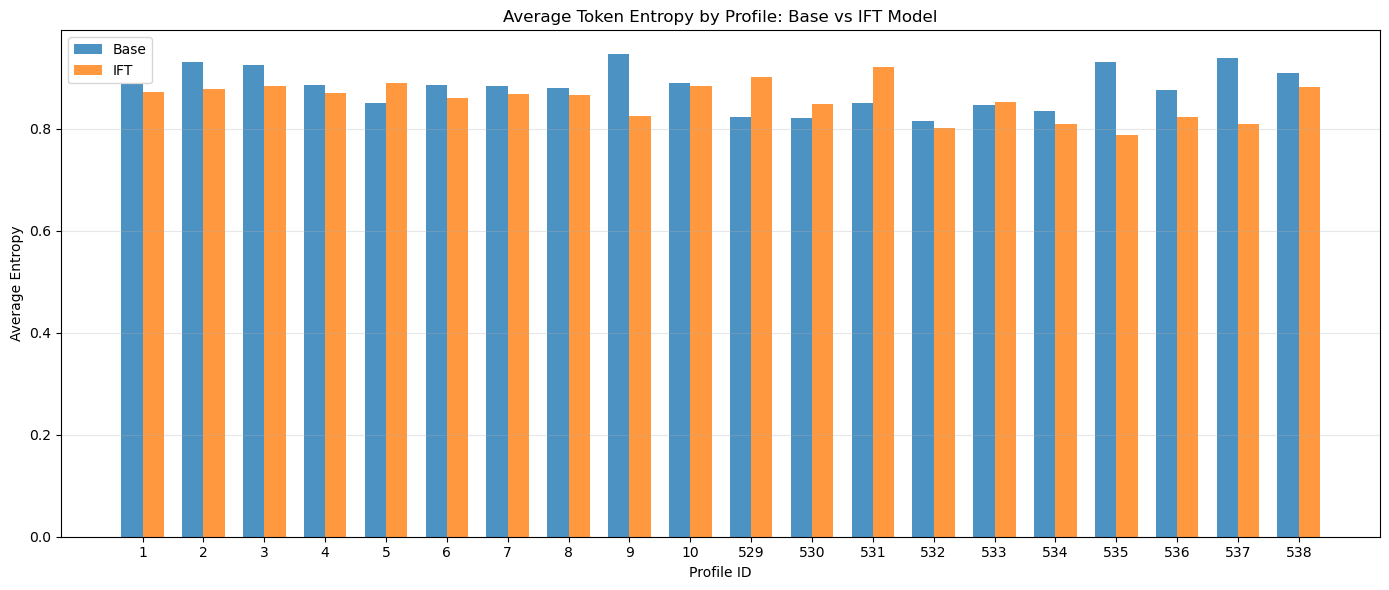

In [10]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load your data
with open(entropy_analysis, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Organize data by profile and model
profiles = {}
for analysis in data['analyses']:
    profile_id = analysis['profile_id']
    model = analysis['model']
    avg_entropy = analysis['avg_entropy']
    
    if profile_id not in profiles:
        profiles[profile_id] = {'base': [], 'ift': []}
    
    profiles[profile_id][model].append(avg_entropy)

# Calculate mean entropy for each profile-model combination
profile_ids = sorted(profiles.keys(), key=lambda x: int(x))
base_means = [np.mean(profiles[pid]['base']) for pid in profile_ids]
ift_means = [np.mean(profiles[pid]['ift']) for pid in profile_ids]

# Create the plot
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(profile_ids))
width = 0.35

bars1 = ax.bar(x - width/2, base_means, width, label='Base', alpha=0.8)
bars2 = ax.bar(x + width/2, ift_means, width, label='IFT', alpha=0.8)

ax.set_xlabel('Profile ID')
ax.set_ylabel('Average Entropy')
ax.set_title('Average Token Entropy by Profile: Base vs IFT Model')
ax.set_xticks(x)
ax.set_xticklabels(profile_ids)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

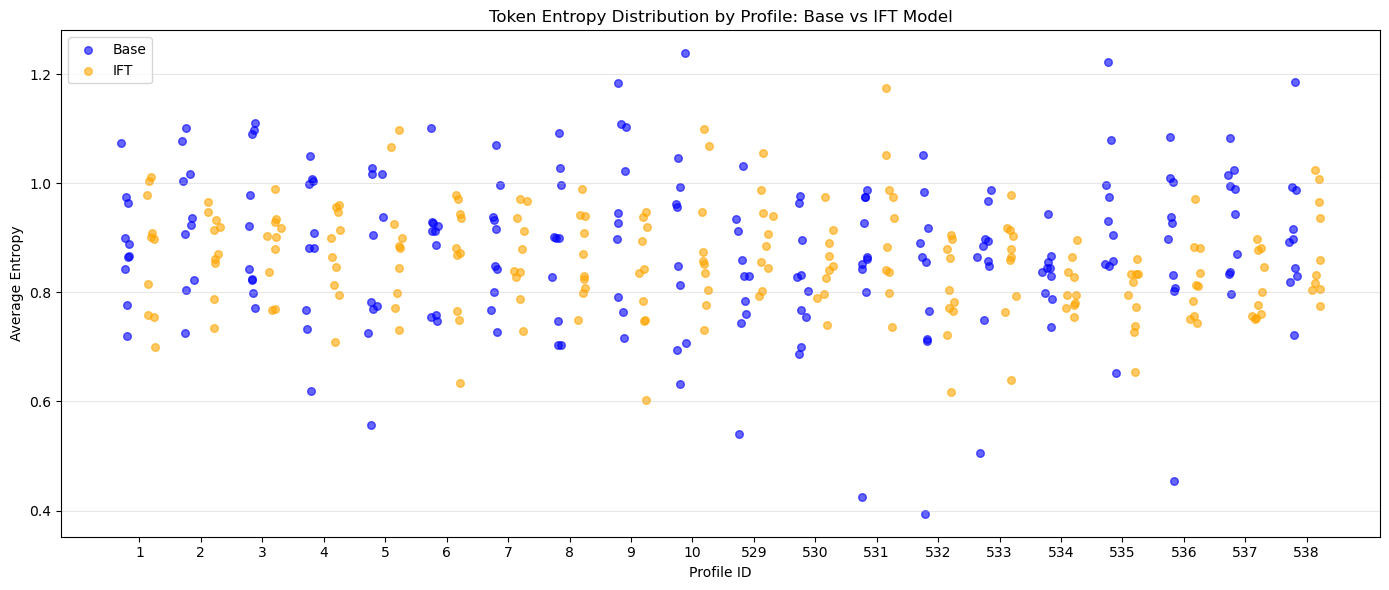

In [11]:
fig, ax = plt.subplots(figsize=(14, 6))

for i, profile_id in enumerate(profile_ids):
    base_entropies = profiles[profile_id]['base']
    ift_entropies = profiles[profile_id]['ift']
    
    # Add some jitter so points don't overlap
    base_x = np.random.normal(i - 0.2, 0.05, size=len(base_entropies))
    ift_x = np.random.normal(i + 0.2, 0.05, size=len(ift_entropies))
    
    ax.scatter(base_x, base_entropies, alpha=0.6, c='blue', s=30, label='Base' if i == 0 else '')
    ax.scatter(ift_x, ift_entropies, alpha=0.6, c='orange', s=30, label='IFT' if i == 0 else '')

ax.set_xlabel('Profile ID')
ax.set_ylabel('Average Entropy')
ax.set_title('Token Entropy Distribution by Profile: Base vs IFT Model')
ax.set_xticks(range(len(profile_ids)))
ax.set_xticklabels(profile_ids)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

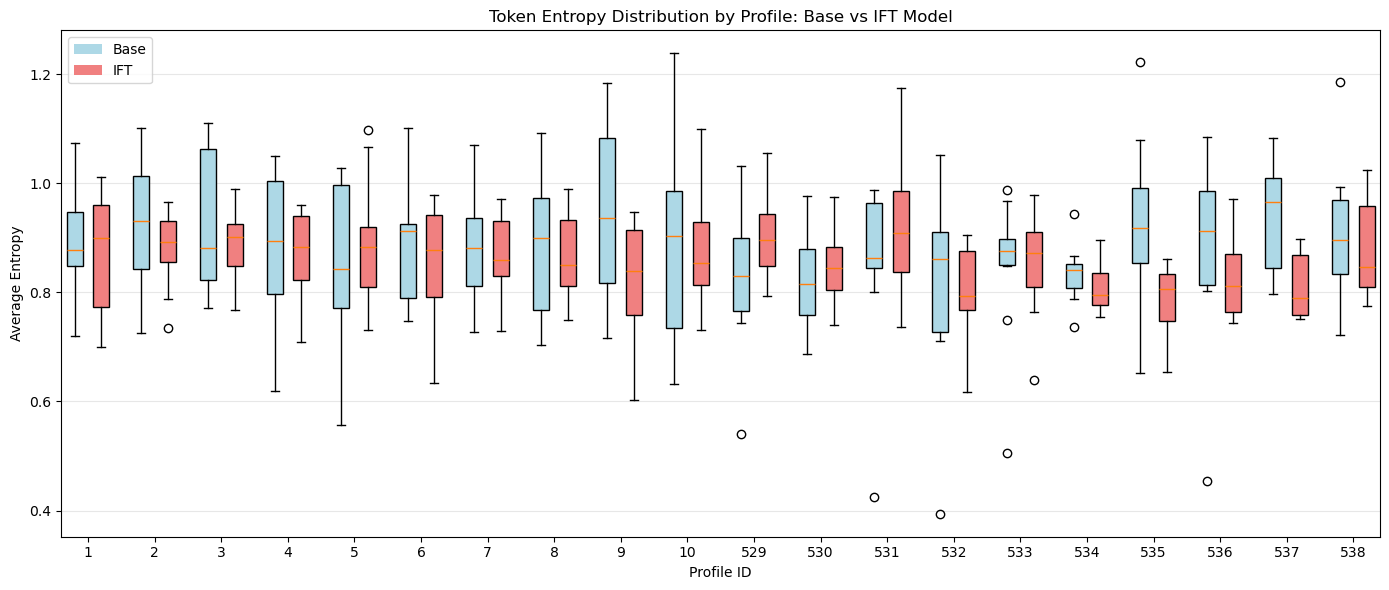

In [12]:
fig, ax = plt.subplots(figsize=(14, 6))

positions = []
data_to_plot = []
colors = []

for i, profile_id in enumerate(profile_ids):
    positions.extend([i * 2.5, i * 2.5 + 1])
    data_to_plot.extend([profiles[profile_id]['base'], profiles[profile_id]['ift']])
    colors.extend(['lightblue', 'lightcoral'])

bp = ax.boxplot(data_to_plot, positions=positions, widths=0.6, patch_artist=True)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xlabel('Profile ID')
ax.set_ylabel('Average Entropy')
ax.set_title('Token Entropy Distribution by Profile: Base vs IFT Model')
ax.set_xticks([i * 2.5 + 0.5 for i in range(len(profile_ids))])
ax.set_xticklabels(profile_ids)

# Create legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='lightblue', label='Base'),
                   Patch(facecolor='lightcoral', label='IFT')]
ax.legend(handles=legend_elements)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

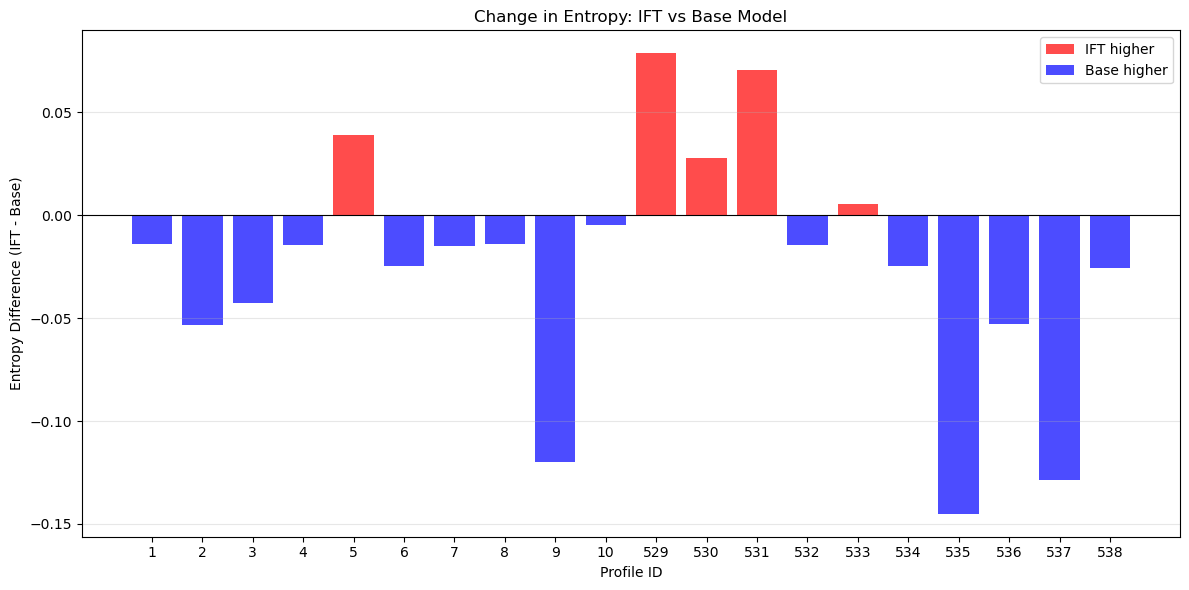

In [13]:
# difference plot showing which direction the effect is going
fig, ax = plt.subplots(figsize=(12, 6))

differences = [np.mean(profiles[pid]['ift']) - np.mean(profiles[pid]['base']) 
               for pid in profile_ids]

colors = ['red' if d > 0 else 'blue' for d in differences]
bars = ax.bar(range(len(profile_ids)), differences, color=colors, alpha=0.7)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Profile ID')
ax.set_ylabel('Entropy Difference (IFT - Base)')
ax.set_title('Change in Entropy: IFT vs Base Model')
ax.set_xticks(range(len(profile_ids)))
ax.set_xticklabels(profile_ids)
ax.grid(axis='y', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', alpha=0.7, label='IFT higher'),
                   Patch(facecolor='blue', alpha=0.7, label='Base higher')]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

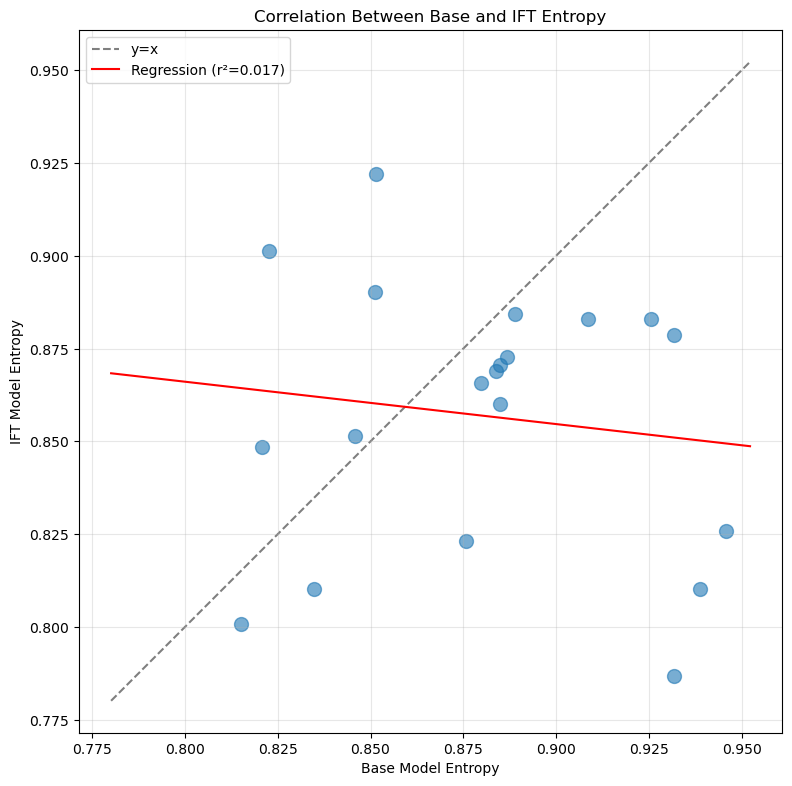

In [16]:
# scatter plot with regression line
fig, ax = plt.subplots(figsize=(8, 8))

base_means = [np.mean(profiles[pid]['base']) for pid in profile_ids]
ift_means = [np.mean(profiles[pid]['ift']) for pid in profile_ids]

ax.scatter(base_means, ift_means, s=100, alpha=0.6)

# Add diagonal line (y=x)
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), 
        max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, 'k--', alpha=0.5, zorder=0, label='y=x')

# Add regression line
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(base_means, ift_means)
line_x = np.array(lims)
line_y = slope * line_x + intercept
ax.plot(line_x, line_y, 'r-', label=f'Regression (r²={r_value**2:.3f})')

ax.set_xlabel('Base Model Entropy')
ax.set_ylabel('IFT Model Entropy')
ax.set_title('Correlation Between Base and IFT Entropy')
ax.legend()
ax.grid(alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

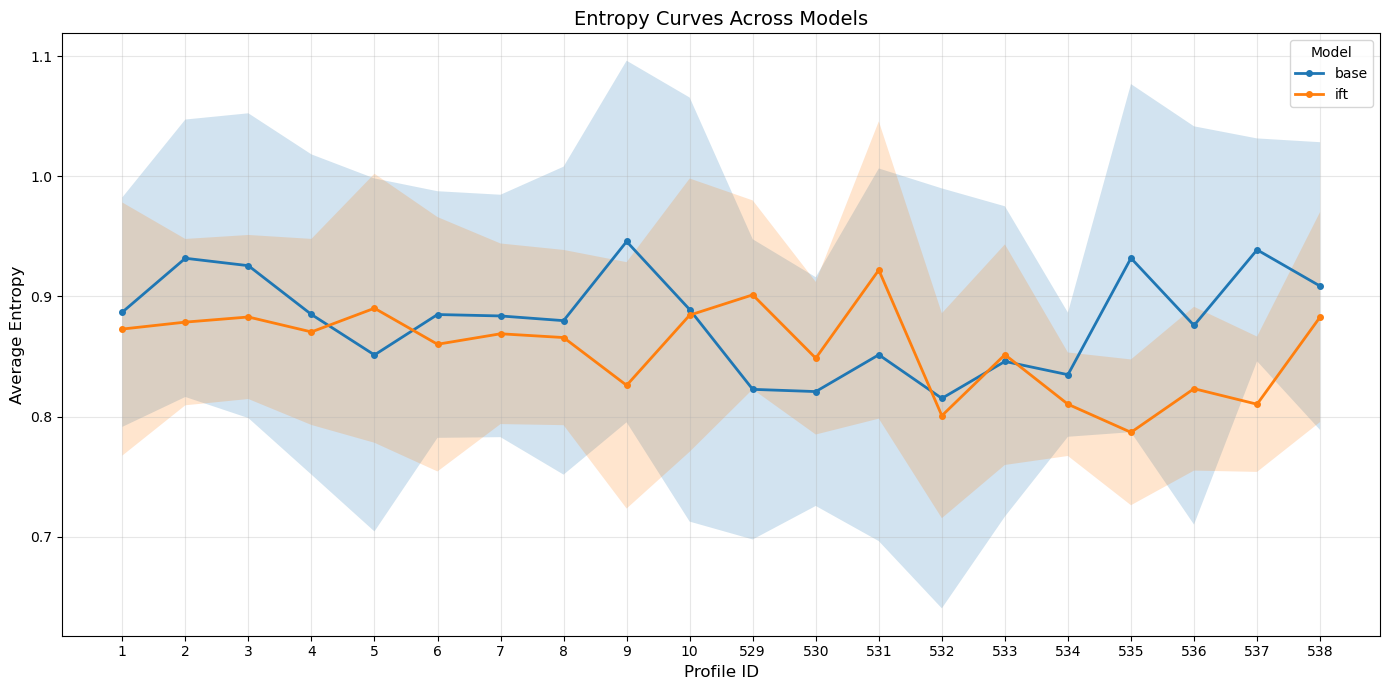

In [19]:
# Line plot with error bands
import json
import matplotlib.pyplot as plt
import numpy as np

# Load data
with open(entropy_analysis, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Organize data by profile and model
profiles = {}
for analysis in data['analyses']:
    profile_id = analysis['profile_id']
    model = analysis['model']
    avg_entropy = analysis['avg_entropy']
    
    if profile_id not in profiles:
        profiles[profile_id] = {}
    if model not in profiles[profile_id]:
        profiles[profile_id][model] = []
    
    profiles[profile_id][model].append(avg_entropy)

# Get all unique models and profiles
profile_ids = sorted(profiles.keys(), key=lambda x: int(x))
all_models = set()
for pid in profile_ids:
    all_models.update(profiles[pid].keys())
all_models = sorted(all_models)

# Calculate statistics for each model across profiles
fig, ax = plt.subplots(figsize=(14, 7))

for model in all_models:
    means = []
    stds = []
    
    for pid in profile_ids:
        if model in profiles[pid]:
            entropies = profiles[pid][model]
            means.append(np.mean(entropies))
            stds.append(np.std(entropies))
        else:
            means.append(np.nan)
            stds.append(np.nan)
    
    means = np.array(means)
    stds = np.array(stds)
    x = np.arange(len(profile_ids))
    
    # Plot line with error band
    ax.plot(x, means, marker='o', label=model, linewidth=2, markersize=4)
    ax.fill_between(x, means - stds, means + stds, alpha=0.2)

ax.set_xlabel('Profile ID', fontsize=12)
ax.set_ylabel('Average Entropy', fontsize=12)
ax.set_title('Entropy Curves Across Models', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(profile_ids)
ax.legend(title='Model', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()